# Gesture Recognition
In this group project, you are going to build a Conv 2D with RNN model that will be able to predict the 5 gestures correctly. Please import the following libraries to get started.

#### Gesture Recognition Case Study ####
Team Members:
1. Megha Sahay
2. Yash Mishra

# Gesture Recognition
In this case, we will be using a CNN2D + RNN Network for evaluating gestures in videos. 
The data provided as following features
1. 30 Video frames in each video
2. Each frame - 3 Channel (RGB)
3. 5 kinds of gestures (Up, Down, Right, Left, Stop)

The objective is to be fullfilled for a hypothetical Smart TV company which is trying to incorporate gesture recognition in its product. The meaning of gesture is summarised in the table below:

Gesture   |       Left       |    Right    |    Stop      |    Down     |     Up
----------| -----------------|-------------|--------------|-------------|-----------
Objectives| Previous Channel | Next Channel| Stop Playing | Volume Down | Volume Up
Y Value (Integer) | 0 | 1 | 2 | 3 | 4 

In [1]:
import numpy as np
import os
# from scipy.misc import imread, imresize -- This import is deprecated so using cv2 (openCV) instead.
import cv2
import datetime
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob
from IPython.display import clear_output # This will be used in developing call back for realtime plot

We set the random seed so that the results don't vary drastically.

In [2]:
np.random.seed(30)
import random as rn
rn.seed(30)
import tensorflow as tf
#from tensorflow import keras 
# We are using tensorflow > 2.0 so we will import keras as 'from tensorflow import keras.*'
from tensorflow.keras import backend as K
# tf.set_random_seed(30)# This method is deprecated hence using tf.random.set_seed()
tf.random.set_seed(30)

In [3]:
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, Flatten, BatchNormalization, ZeroPadding3D,Activation,SimpleRNN,Bidirectional
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
#from tensorflow.keras import optimizers
import re
from tensorflow.keras.layers import Dropout
%matplotlib inline

In [4]:
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.layers import LSTM, GRU

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [5]:
# Declaring the path of the project data.
path_data = r'C:\Data\Project_data'

In [6]:
# Read the train.csv and val.csv files.
train_doc = np.random.permutation(open(os.path.join(path_data,'','train.csv')).readlines())
val_doc = np.random.permutation(open(os.path.join(path_data,'','val.csv')).readlines())
batch_size = 10 #experiment with the batch size

In [7]:
# Checking the last 10 records of train_doc
train_doc[:10]

array(['WIN_20180926_16_54_08_Pro_Right_Swipe_new;Right_Swipe_new;1\n',
       'WIN_20180925_18_02_58_Pro_Thumbs_Down_new;Thumbs_Down_new;3\n',
       'WIN_20180925_17_33_08_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180925_17_51_17_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_17_35_Pro_Left_Swipe_new;Left_Swipe_new;0\n',
       'WIN_20180926_17_30_47_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_23_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180926_17_12_26_Pro_Thumbs_Up_new;Thumbs_Up_new;4\n',
       'WIN_20180926_17_29_01_Pro_Stop_new;Stop_new;2\n',
       'WIN_20180907_16_32_11_Pro_Stop Gesture_new;Stop Gesture_new;2\n'],
      dtype='<U88')

# Observations
- The train_doc is an array containing the folder name , the class name and the class label.

# Lets us define some methods.

In [8]:
'''This method will count the trainable weights and non-trainable weights for a given model'''
def param_count(model):
    
    trainable_count = np.sum([K.count_params(w) for w in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(w) for w in model.non_trainable_weights])

    print('Total params: {:,}'.format(trainable_count + non_trainable_count))
    print('Trainable params: {:,}'.format(trainable_count))
    print('Non-trainable params: {:,}'.format(non_trainable_count))
    return [trainable_count + non_trainable_count, trainable_count, non_trainable_count]

In [9]:
'''This method will annotate the bar plots with the corresponding y(numeric) values.'''
def annotate_graph(ax):
    for bar in ax.patches:         
        ax.annotate(format((bar.get_height()), '.2f'), 
                    (bar.get_x() + bar.get_width() / 2,  bar.get_height()),                    
                    ha='center', va='center',                    
                    size=10, xytext=(0, 8),                    
                    textcoords='offset points')     
    return ax

# Note

Several different batch sizes were tried: 2048, 1024, 512, 128. ResourceExhausted Error was thrown till batch size = 128. 

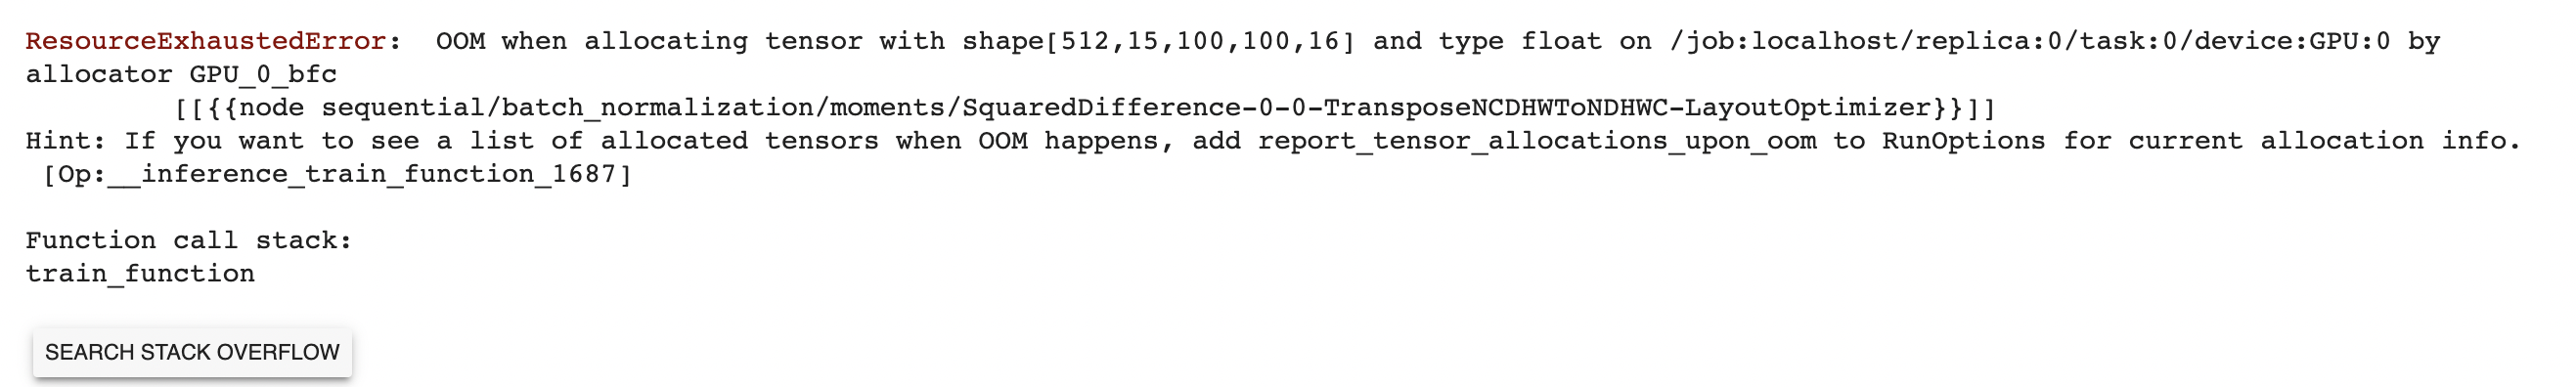

## Conclusion 
- Keeping large batch size was negatively affecting performance. 

- This observation is backed up by further resources as well. One such resource: 
  
  https://datascience.stackexchange.com/questions/12532/does-batch-size-in-keras-have-any-effects-in-results-quality


## Image Processor
The objective of this function is:
Resize the images as per *transform_size* given by user, or resize it to a fixed size of (100,100).

**Reason**

In the training data we have 2 types of videos, where video frame size are as *(360,360)* and *(160,120)* Therefore to keep things consistent, we build an image processor which will perform cropping of the images.

**Note**

Cropping is done as a centered image, i.e., we take the center as the reference and crop the images from both sides. For (360,360) we can use skimage.transform.resize function. However, for *(160,120)* we will have to some manual processing to crop images by the center.

In [10]:
'''This method is used to process image based on its shape 
if image is of dimension (360,360,3) then we will use resize to (100,100,1)
else we will manual crop image of any other dimension '''
from skimage.transform import resize
def image_processor(original_image,transform_size = (100,100)):
    # If we have an image of (360,360,3) then we use resize function.
    new_image = original_image
    if original_image.shape == (360,360,3):
        new_image = resize(original_image,transform_size)
    else:
        # Manually crop the image using the below logic.
        start_row = (original_image.shape[0] - transform_size[0])//2
        end_row = start_row + transform_size[0]
            
        start_col = (original_image.shape[1] - transform_size[1])//2
        end_col = start_col + transform_size[1]
        new_image = original_image[start_row:end_row,start_col:end_col,:]
    return new_image

#### Sequence Generator ####
This function provides a list of frame sequences we would like to use for training.

Arguments

a) choice_of_list


choice_of_list | 0 | 1 | 2
-----------|---|---|---
Return list type | range(0,30,1) | range(0,30,2) | [0,1,2,3,4,5,6,9,12,15,18,21,24,25,26,27,28,29]

In [11]:

def get_frame_selection_list(choice_of_list=0):
    if choice_of_list == 0:
        return [frame for frame in range(0,30,1)] # Returns 100% of frames, number of frames=30
    elif choice_of_list == 1:
        return [frame for frame in range(0,30,2)] # returns 50% of frames, number of frames=15
    elif choice_of_list == 2:
        # For this we are taking first 5 frame + skip frame sequence + last 5 frame of the sequence
        frame_sequences = []
        start_frame_sequence = [0,1,2,3,4,5]
        end_frame_sequence = [25,26,27,28,29]
        skip_sequence = 3
        mid_frame_sequence = [k for k in range(6,25,skip_sequence)]
        
        frame_sequences.extend(start_frame_sequence)
        frame_sequences.extend(mid_frame_sequence)
        frame_sequences.extend(end_frame_sequence)
         
        return frame_sequences
    

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

This is heart of complete training process. It pumps batched data to network during learning and prediction both. The function description is given below:

Arguments

1. Source Path - Directory/Folder path to be considered for reading video/images frames.
2. folder_list - Lines from the train_doc we read above.
3. batch_size - The batch_size we want to select.
4. transform_size - The image transformation size we (Default - (100,100))
5. frame_selection - frame_list obtained from frame_generator (Default - range(30))
6. process_input_func - To be provided in case CNN2D+RNN type modelling being done.
7. base_model - To be provided in case CNN2D+RNN type modelling being done.

***Case 1 - when CNN2D+RNN modelling being done (RNN can be any of SimpleRNN/LSTM/GRU)***

In this case, for each batch (according to batch size), we build

1. **batch_data** = *(batch_size, number_of_frames,image_size_x,image_size_y,n_channels)*
2. reshape batch data as **batch_data.reshape(batch_size * number_of_frames , image_size_x , image_size_y , n_channels)**.
3. Above reshaped numpy array is sent to *process_input_func* of the pre-learned CNN2D function. This will produce modified image vector as per pre-learned CNN2D function (like VGG19/VGG16/etc.)
4. After *process_input_func* we reshape again to *(batch_size, number_of_frames, outputs from CNN2D vector)*

***Case 2 - when CNN3D modelling being done***

In this case, for each batch (according to batch size), we build 

1. **batch_data** = *(batch_size, number_of_frames,image_size_x,image_size_y,n_channels)*
2. We normalize each channel (RGB) by dividing the pixel value with 255.



***Final Output***

The final output of the function has a tuple which has the batch_data (processed) and one-hot-encoded Y variable.
One-hot-encoded numpy array will be of size (batch_size, 5) since we have 5 types of gestures.



In [12]:
def generator(source_path, folder_list, batch_size,frame_selection = range(30),process_input_func=None,base_model = None):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    #index_selection = [i for i in range(0,30,2)] #create a list of image numbers you want to use for a particular video
    img_idx = frame_selection #create a list of image numbers you want to use for a particular video
    
    x = len(img_idx) #x: number of images used for each video
    y = 100 # image height
    z = 100 # width height
    channels = 3 # Number of channels
    transform_size = (100,100)# The size we want to crop the original image.
    
    while True:
        t = np.random.permutation(folder_list)
        num_batches = len(t)//(batch_size)  # calculate the number of batches
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size,x,y,z,channels)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output (output: 0,1,2,3,4. Hence 5 possible outputs)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image_path= source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                    
                    #Crop the images and resize them. Note that the images are of 2 different shapes 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image= image_processor(image,transform_size)   ##Crops Rectangular frames of 120x160 to 120x120
                    if base_model:
                        # This is when we are using a pre-learned CNN2D network
                        image = process_input_func(image)
                        
                    else:
                        # This is when we are building a Conv3D network
                        image = cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)  #Resizing 360x360 and 120x120 (cropped) images to 100x100

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if base_model:
                s1 = batch_data.shape
                n1 = base_model.predict(batch_data.reshape(s1[0]*s1[1],s1[2],s1[3],s1[4]))
                s2 = n1.shape
                batch_data = n1.reshape(s1[0],s1[1],s2[1]*s2[2]*s2[3])
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # write the code for the remaining data points which are left after full batches
        if len(t) % batch_size != 0:
            batch_size= len(t) - (num_batches*batch_size)
            batch= num_batches
            batch_data = np.zeros((batch_size,x,y,z,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output (output: 0,1,2,3,4. Hence 5 possible outputs)
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image_path= source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]
                    image = cv2.imread(image_path, cv2.IMREAD_COLOR).astype(np.float32)
                    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

                    #crop the images and resize them. Note that the images are of 2 different shapes 
                    #and the conv3D will throw error if the inputs in a batch have different shapes

                    image= image_processor(image,transform_size)   ##Crops Rectangular frames of 120x160 to 120x120
                    if base_model:
                        # This is when we are using a pre-learned CNN2D network
                        image = process_input_func(image)
                        
                    else:
                        # This is when we are building a Conv3D network
                        image = cv2.resize(image, (y,z), interpolation = cv2.INTER_AREA)  #Resizing 360x360 and 120x120 (cropped) images to 100x100

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255 #normalise and feed in the image
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255 #normalise and feed in the image
    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            if base_model:
                s1 = batch_data.shape
                n1 = base_model.predict(batch_data.reshape(s1[0]*s1[1],s1[2],s1[3],s1[4]))
                s2 = n1.shape
                batch_data = n1.reshape(s1[0],s1[1],s2[1]*s2[2]*s2[3])
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [13]:
curr_dt_time = datetime.datetime.now()
train_path = os.path.join(path_data,'','train')#'/notebooks/storage/Final_data/Collated_training/train'
val_path = os.path.join(path_data,'','val')#'/notebooks/storage/Final_data/Collated_training/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
num_epochs = 60 # choose the number of epochs
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 60


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.



#### Setting up extra parameter for Neural Network ####

* ModelCheckPoint

We build modelcheckpoint to save models after every epoch, so that we can refer to models to best model later on for final testing.
* ReduceLROnPlateau

If the **val_loss** value stops improving after **patience** number of epochs, we reduce the learning rate so as to take smaller steps down the gradient route for reaching global minimum and avoid getting stuch at local minimum.


# Defining some methods here.

In [14]:
'''This method is used to save model .h5 file in the 
specified path as save_model/{model_type}/{model_num}
if this path does not exist then it will create one to save the model'''
def get_model_save_path(model_type='conv2d_RNN',model_num='Model1'):
    
    file_folder = 'save_model/'+model_type+'/'+model_num+'/'
    
    if not os.path.exists('save_model/'+model_type+'/'):
        os.mkdir('save_model/'+model_type+'/')
        
    if not os.path.exists(file_folder):
        os.mkdir(file_folder)
        
    save_file_name='model_init-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'    
    file_path = file_folder+save_file_name

    return file_path

In [15]:
'''This method will create the model check point and 
will write the log to the metric.csv file for each model'''
def get_model_callback_list(model_name,model_num):
    
    file_path = get_model_save_path(model_name,model_num)
    
    checkpoint = ModelCheckpoint(file_path, 
                                 monitor='val_loss', 
                                 verbose=1,
                                 save_best_only=False,
                                 save_weights_only=False,
                                 mode='auto',
                                 save_freq='epoch')
    
    #early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
    #earlystop = tf.keras.callbacks.EarlyStopping( monitor='val_loss', mode='min', verbose=1, patience=15)
    
    # write the REducelronplateau code here
    LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                           patience=5, min_lr=0.001,verbose=1)
    #Logging all evaluation metrics
    csv_logger= CSVLogger(os.path.join(os.path.dirname(file_path),'','metric_log.csv')
                                      , append=True,
                                      separator=',')
    
 
    #return [csv_logger,checkpoint,LR,earlystop],file_path
    return [csv_logger,checkpoint,LR],file_path

In [16]:
'''This latest .h5 file with its paths information so that when we start training a 
model and in case GPU crashes we will be abale to start traing from that specific epoch
without any need to train again from first epoch.
This will save GPU and is less time taking'''
def get_latest_check_point(file_path):
    folder_path=os.path.dirname(file_path)
    metric_path=os.path.join(folder_path,'','metric_log.csv')
    if os.path.exists(metric_path):
        df_metric=pd.read_csv(metric_path)
        latest=list(df_metric.epoch)[-1]+1
        search_string = "model_init-0{3,}"+str(latest)+"{1}[a-z0-9\-\.]*"
        latest_file=[f for f in os.listdir(folder_path) if re.search(search_string, f)][0]
        
    else:
        latest_file='No weight and model is saved yet.'
        latest=None
    print("Latest model name : %s" %(latest_file))
    print("Latest Epoch is %s" %(latest))
  
    return os.path.join(folder_path,'',latest_file),latest

In [17]:
'''This method will give the file path of the best model with maximum val_categorical_accuracy'''
def get_best_check_point(file_path):
    folder_path=os.path.dirname(file_path)
    metric_path=os.path.join(folder_path,'','metric_log.csv')
    if os.path.exists(metric_path):
        df_metric=pd.read_csv(metric_path)
        best_epoch=np.argmax(df_metric.val_categorical_accuracy)+1 #best epoch is where val_categorical_accuracy is maximum
        search_string = "model_init-0{3,}"+str(best_epoch)+"{1}[a-z0-9\-\.]*"
        best_file=[f for f in os.listdir(folder_path) if re.search(search_string, f)][0]
        print("Best model name : %s" %(best_file))
        print("Best Epoch is %s" %(best_epoch))
        
        val_categorical_accuracy=df_metric.val_categorical_accuracy.max()
        categorical_accuracy=df_metric['categorical_accuracy'][best_epoch-1]  
        print("Best model validation accuracy is :" ,val_categorical_accuracy)
        print("Best model train accuracy is :" ,categorical_accuracy)
    
    else:
        best_file = None
        best_epoch = None
        print("Model log and history not found in folder: ",file_path)
 
    return os.path.join(folder_path,'',best_file),best_epoch,[categorical_accuracy,val_categorical_accuracy]

In [18]:
'''As we are writing the log in csv file this method will pick the metric from the csv log file 
and will plot the loss and accuracy'''
def draw_evaluation_metric(file_path):
    metric_path=os.path.join(os.path.dirname(file_path),'','metric_log.csv')
    df_metric=pd.read_csv(metric_path)
    latest=np.argmax(df_metric.epoch)
    
    df_loss=df_metric[['loss','val_loss']]
    df_acc=df_metric[['categorical_accuracy','val_categorical_accuracy']]
    
    f,ax=plt.subplots(1,2,figsize=(15,5))
    
    ax[0].plot(range(1,latest+2),list(df_loss.loss),label='loss')
    ax[0].plot(range(1,latest+2),list(df_loss.val_loss),label='val_loss')
    ax[0].legend()
    ax[0].grid()

    ax[1].plot(range(1,latest+2),list(df_acc.categorical_accuracy),
           label='categorical_accuracy')
    ax[1].plot(range(1,latest+2),list(df_acc.val_categorical_accuracy)
           ,label='val_categorical_accuracy')
    ax[1].legend()
    ax[1].grid()

In [19]:
# These lists will be used to carry the model performance indicators. 
name = []
total_params = []
trainable_params = []
non_trainable_params = []
categorical_accuracy = []
val_categorical_accuracy = []
paths = []

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [20]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

# Conv2D + Simple RNN Model
## Model 1 with 32 kernal/filters with 3 X 3 size in the first layer

In [21]:
input_shape = (len(get_frame_selection_list(choice_of_list=1)),100,100,3)
input_shape

(15, 100, 100, 3)

In [22]:
batch_size = 16
train_generator = generator(train_path, train_doc, batch_size,frame_selection = get_frame_selection_list(choice_of_list=1))
val_generator = generator(val_path, val_doc, batch_size,frame_selection = get_frame_selection_list(choice_of_list=1))

In [23]:
# model1
tf.keras.backend.clear_session()


model1 = Sequential()

#1st Conv2D group
model1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
model1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
model1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model1.add(TimeDistributed(BatchNormalization()))
model1.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
model1.add(TimeDistributed(Flatten()))
#LSTM
model1.add(SimpleRNN(128, return_sequences=False, dropout=0.1))
model1.add(Dense(64,activation='relu'))
model1.add(Dropout(0.1))

#Softmax layer
model1.add(Dense(5, activation='softmax'))

In [24]:
optimiser = tf.keras.optimizers.Adam() #write your optimizer
model1.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model1.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100, 100, 32)  9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 64)    2

In [25]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model1')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model1


In [26]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [27]:
if latest_epoch==None:
    last_epoch=0
    
else:
    last_epoch=latest_epoch #Start training where we left using initial_epoch
    
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)
    
    model1_fit = tf.keras.models.load_model(latest_weight)

model1_fit = model1.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1) 

Source path =  C:\Data\Project_data\train ; batch size = 16
Epoch 1/60
67/67 [==============================] - 102s 1s/step - loss: 1.3864 - categorical_accuracy: 0.4224 - val_loss: 2.4549 - val_categorical_accuracy: 0.1875

Epoch 00001: saving model to save_model/conv2d_RNN/model1\model_init-00001-1.38638-0.42243-2.45492-0.18750.h5
Epoch 2/60
67/67 [==============================] - 44s 656ms/step - loss: 1.3354 - categorical_accuracy: 0.4542 - val_loss: 2.3041 - val_categorical_accuracy: 0.1500

Epoch 00002: saving model to save_model/conv2d_RNN/model1\model_init-00002-1.33542-0.45416-2.30408-0.15000.h5
Epoch 3/60
67/67 [==============================] - 33s 494ms/step - loss: 1.4681 - categorical_accuracy: 0.3628 - val_loss: 1.6243 - val_categorical_accuracy: 0.3000

Epoch 00003: saving model to save_model/conv2d_RNN/model1\model_init-00003-1.46807-0.36283-1.62433-0.30000.h5
Epoch 4/60
67/67 [==============================] - 34s 509ms/step - loss: 1.5286 - categorical_accuracy: 0.

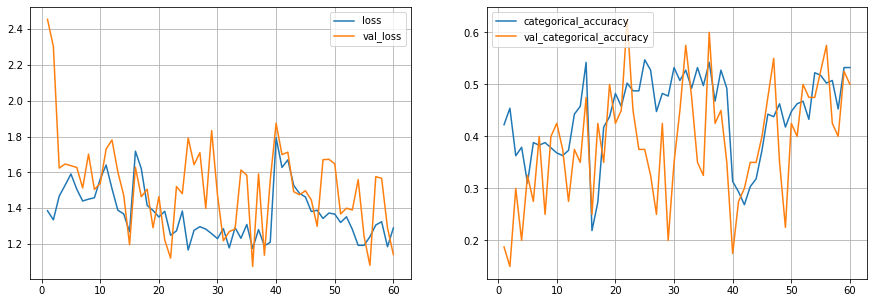

In [28]:
draw_evaluation_metric(file_path)

In [29]:
# Getting the best checpoint and val , categorical accuracy
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00022-1.24942-0.50249-1.12188-0.62500.h5
Best Epoch is 22
Best model validation accuracy is : 0.625
Best model train accuracy is : 0.5024875402450562


In [30]:
param_count_model1 = param_count(model1)

name.append('model1-SimpleRNN')
total_params.append(param_count_model1[0] )
trainable_params.append(param_count_model1[1] )
non_trainable_params.append(param_count_model1[2] )


categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 2,673,189
Trainable params: 2,672,293
Non-trainable params: 896


# Observations
- As seen the above graph this model has very low validation accuracy.
- So we will try creating an LSTM model and check if we can get better accuracy.

# Conv2D + RNN (LSTM) Model

## Model 2 with 32,64,128 kernal/filters with 3 X 3 size.

In [31]:
# model2
tf.keras.backend.clear_session()
model2 = Sequential()

#1st Conv2D group
model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
model2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
model2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model2.add(TimeDistributed(BatchNormalization()))
model2.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
model2.add(TimeDistributed(Flatten()))
#LSTM
model2.add(LSTM(128, return_sequences=False, dropout=0.1))
model2.add(Dense(64,activation='relu'))
model2.add(Dropout(0.1))

#Softmax layer
model2.add(Dense(5, activation='softmax'))

In [32]:
optimiser = Adam() #write your optimizer
model2.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model2.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100, 100, 32)  9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 64)    2

In [33]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model2')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model2


In [34]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [35]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)
    
    model2_fit = tf.keras.models.load_model(latest_weight)

model2_fit = model2.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1) 

Epoch 1/60
67/67 [==============================] - 25s 325ms/step - loss: 1.5598 - categorical_accuracy: 0.2537 - val_loss: 1.6980 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to save_model/conv2d_RNN/model2\model_init-00001-1.55979-0.25373-1.69799-0.15000.h5
Epoch 2/60
67/67 [==============================] - 21s 322ms/step - loss: 1.4885 - categorical_accuracy: 0.3781 - val_loss: 1.8982 - val_categorical_accuracy: 0.2250

Epoch 00002: saving model to save_model/conv2d_RNN/model2\model_init-00002-1.48852-0.37811-1.89816-0.22500.h5
Epoch 3/60
67/67 [==============================] - 22s 329ms/step - loss: 1.4792 - categorical_accuracy: 0.3582 - val_loss: 2.0386 - val_categorical_accuracy: 0.1500

Epoch 00003: saving model to save_model/conv2d_RNN/model2\model_init-00003-1.47918-0.35821-2.03862-0.15000.h5
Epoch 4/60
67/67 [==============================] - 21s 316ms/step - loss: 1.3527 - categorical_accuracy: 0.4428 - val_loss: 1.5891 - val_categorical_accuracy: 0.2750

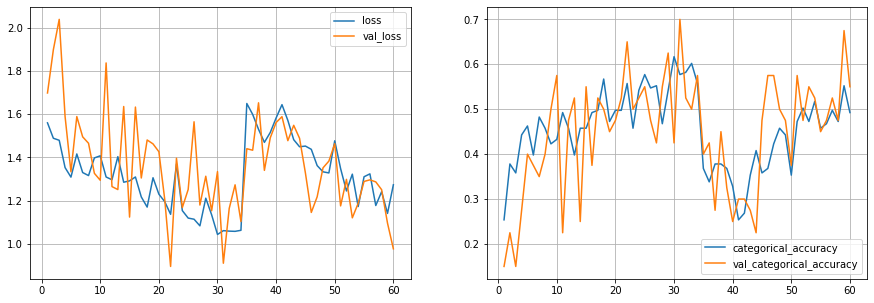

In [36]:
draw_evaluation_metric(file_path)

In [37]:
# Getting the best checpoint and val , categorical accuracy
path,best_epoch,metric_parms = get_best_check_point(file_path)

Best model name : model_init-00031-1.06108-0.57711-0.91030-0.70000.h5
Best Epoch is 31
Best model validation accuracy is : 0.699999988079071
Best model train accuracy is : 0.5771144032478333


In [38]:
param_count_model2 = param_count(model2)

name.append('model2-LSTM')
total_params.append(param_count_model2[0] )
trainable_params.append(param_count_model2[1] )
non_trainable_params.append(param_count_model2[2] )


categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 9,800,613
Trainable params: 9,799,717
Non-trainable params: 896


# Observations
- As we can see from above the training and testing accuracy is very low.
- So we will try to improve accuracy by decreasing the number of filters in the layers in next model.

# Model 3 with 16 kernal/filters with 3 X 3 size in the first layer

In [39]:
# Model3
tf.keras.backend.clear_session()
model3 = Sequential()

#1st Conv2D group
model3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
model3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model3.add(TimeDistributed(BatchNormalization()))
model3.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
model3.add(TimeDistributed(Flatten()))
#LSTM
model3.add(LSTM(128, return_sequences=False, dropout=0.1))
model3.add(Dense(64,activation='relu'))
model3.add(Dropout(0.1))

#Softmax Layer
model3.add(Dense(5, activation='softmax'))

In [40]:
optimiser = Adam() #write your optimizer
model3.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model3.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100, 100, 16)  2320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 32)    1

In [41]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model3')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model3


In [42]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [43]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)
    
    model3_fit = tf.keras.models.load_model(latest_weight)

model3_fit = model3.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1) 

Epoch 1/60
67/67 [==============================] - 25s 338ms/step - loss: 1.6790 - categorical_accuracy: 0.1741 - val_loss: 1.6890 - val_categorical_accuracy: 0.2750

Epoch 00001: saving model to save_model/conv2d_RNN/model3\model_init-00001-1.67896-0.17413-1.68900-0.27500.h5
Epoch 2/60
67/67 [==============================] - 20s 301ms/step - loss: 1.5237 - categorical_accuracy: 0.3184 - val_loss: 1.6727 - val_categorical_accuracy: 0.2000

Epoch 00002: saving model to save_model/conv2d_RNN/model3\model_init-00002-1.52373-0.31841-1.67266-0.20000.h5
Epoch 3/60
67/67 [==============================] - 20s 304ms/step - loss: 1.3919 - categorical_accuracy: 0.4577 - val_loss: 1.6187 - val_categorical_accuracy: 0.2250

Epoch 00003: saving model to save_model/conv2d_RNN/model3\model_init-00003-1.39185-0.45771-1.61867-0.22500.h5
Epoch 4/60
67/67 [==============================] - 19s 293ms/step - loss: 1.4764 - categorical_accuracy: 0.4030 - val_loss: 1.4187 - val_categorical_accuracy: 0.4500

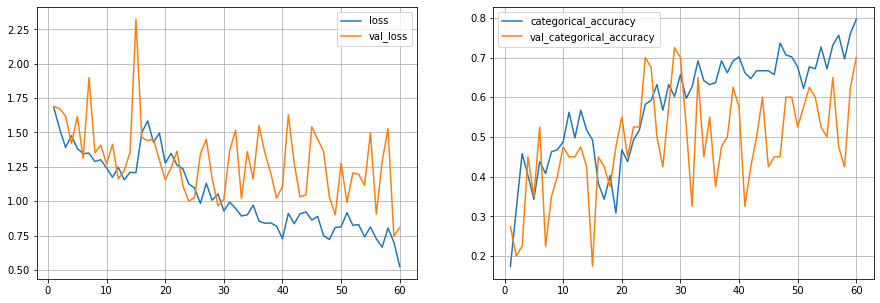

In [44]:
draw_evaluation_metric(file_path)

In [45]:
# Getting the best checpoint and val , categorical accuracy
path,best_epoch,metric_parms = get_best_check_point(file_path)


Best model name : model_init-00029-1.05273-0.60199-0.96729-0.72500.h5
Best Epoch is 29
Best model validation accuracy is : 0.7250000238418579
Best model train accuracy is : 0.6019900441169739


In [46]:
param_count_model3 = param_count(model3)

name.append('model_3-LSTM-less-filters')
total_params.append(param_count_model3[0] )
trainable_params.append(param_count_model3[1] )
non_trainable_params.append(param_count_model3[2] )


categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 4,866,197
Trainable params: 4,865,749
Non-trainable params: 448


# Observations
- There seems to be increase in validation accuracy from the previous model but still not upto mark. 
- We will try to build anothere model by increasing the number of kernels and using GRU.

# Conv2D + RNN (GRU) Model

## Model 4 with 32 kernal/filters with 3 X 3 size in the first layer.

In [47]:
# Model4
tf.keras.backend.clear_session()
model4 = Sequential()

#1st Conv2D group
model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
model4.add(TimeDistributed(BatchNormalization()))
model4.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
model4.add(TimeDistributed(Flatten()))
#GRU
model4.add(GRU(128, return_sequences=False, dropout=0.1))
model4.add(Dense(64,activation='relu'))
model4.add(Dropout(0.1))

#Softmax layer
model4.add(Dense(5, activation='softmax'))

In [48]:
optimiser = Adam() #write your optimizer
model4.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 32)  896       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100, 100, 32)  9248      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 32)  128       
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 32)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 50, 50, 64)    18496     
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 64)    2

In [49]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model4')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model4


In [50]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [51]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)
    
    model4_fit = tf.keras.models.load_model(latest_weight)

model4_fit = model4.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1) 

Epoch 1/60
67/67 [==============================] - 23s 324ms/step - loss: 1.6856 - categorical_accuracy: 0.2338 - val_loss: 1.9530 - val_categorical_accuracy: 0.1500

Epoch 00001: saving model to save_model/conv2d_RNN/model4\model_init-00001-1.68559-0.23383-1.95300-0.15000.h5
Epoch 2/60
67/67 [==============================] - 20s 304ms/step - loss: 1.6317 - categorical_accuracy: 0.2488 - val_loss: 2.0115 - val_categorical_accuracy: 0.1750

Epoch 00002: saving model to save_model/conv2d_RNN/model4\model_init-00002-1.63169-0.24876-2.01149-0.17500.h5
Epoch 3/60
67/67 [==============================] - 21s 320ms/step - loss: 1.5942 - categorical_accuracy: 0.3184 - val_loss: 2.1058 - val_categorical_accuracy: 0.1750

Epoch 00003: saving model to save_model/conv2d_RNN/model4\model_init-00003-1.59419-0.31841-2.10577-0.17500.h5
Epoch 4/60
67/67 [==============================] - 21s 321ms/step - loss: 1.6607 - categorical_accuracy: 0.3035 - val_loss: 1.5482 - val_categorical_accuracy: 0.3500

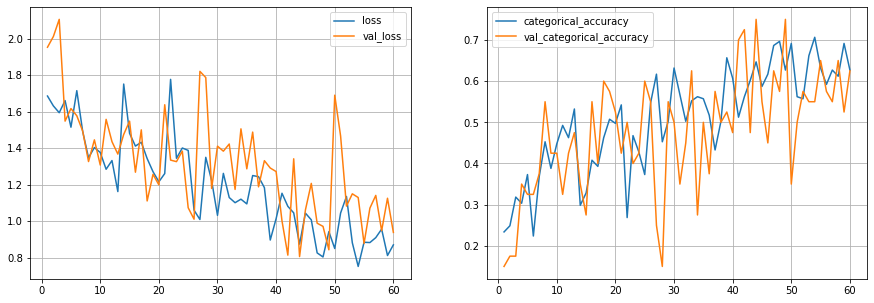

In [52]:
draw_evaluation_metric(file_path)

In [53]:
# Getting the best checpoint and val , categorical accuracy
path,best_epoch,metric_parms = get_best_check_point(file_path)


Best model name : model_init-00044-0.87427-0.64677-0.80590-0.75000.h5
Best Epoch is 44
Best model validation accuracy is : 0.75
Best model train accuracy is : 0.646766185760498


In [54]:
param_count_model4 = param_count(model4)

name.append('model_4-GRU')
total_params.append(param_count_model4[0] )
trainable_params.append(param_count_model4[1] )
non_trainable_params.append(param_count_model4[2] )


categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 7,425,189
Trainable params: 7,424,293
Non-trainable params: 896


# Observations
- The validation accuracy has increased from the last model.
- So we will try reducing the number of filters to 16 and see if there is any improvement in validation accuracy.

# Model 5 reducing the number of filters

In [55]:
# Model5
model5 = Sequential()

#1st Conv2D group
model5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model5.add(TimeDistributed(BatchNormalization()))
model5.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
model5.add(TimeDistributed(Flatten()))
#GRU
model5.add(GRU(128, return_sequences=False, dropout=0.1))
model5.add(Dense(64,activation='relu'))
model5.add(Dropout(0.1))

#Softmax Layer
model5.add(Dense(5, activation='softmax'))

In [56]:
optimiser = Adam() #write your optimizer
model5.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model5.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed_16 (TimeDis (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_17 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_18 (TimeDis (None, 15, 100, 100, 16)  2320      
_________________________________________________________________
time_distributed_19 (TimeDis (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_20 (TimeDis (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_21 (TimeDis (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_22 (TimeDis (None, 15, 50, 50, 32)   

In [57]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model5')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model5


In [58]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [59]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)
    
    model5_fit = tf.keras.models.load_model(latest_weight)

model5_fit = model5.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1) 

Epoch 1/60
67/67 [==============================] - 21s 289ms/step - loss: 1.5628 - categorical_accuracy: 0.3333 - val_loss: 2.1070 - val_categorical_accuracy: 0.2750

Epoch 00001: saving model to save_model/conv2d_RNN/model5\model_init-00001-1.56280-0.33333-2.10704-0.27500.h5
Epoch 2/60
67/67 [==============================] - 20s 301ms/step - loss: 1.4161 - categorical_accuracy: 0.4080 - val_loss: 2.8371 - val_categorical_accuracy: 0.3250

Epoch 00002: saving model to save_model/conv2d_RNN/model5\model_init-00002-1.41615-0.40796-2.83713-0.32500.h5
Epoch 3/60
67/67 [==============================] - 18s 277ms/step - loss: 1.3966 - categorical_accuracy: 0.4478 - val_loss: 2.0689 - val_categorical_accuracy: 0.2500

Epoch 00003: saving model to save_model/conv2d_RNN/model5\model_init-00003-1.39662-0.44776-2.06889-0.25000.h5
Epoch 4/60
67/67 [==============================] - 20s 296ms/step - loss: 1.2561 - categorical_accuracy: 0.4577 - val_loss: 1.7886 - val_categorical_accuracy: 0.2750

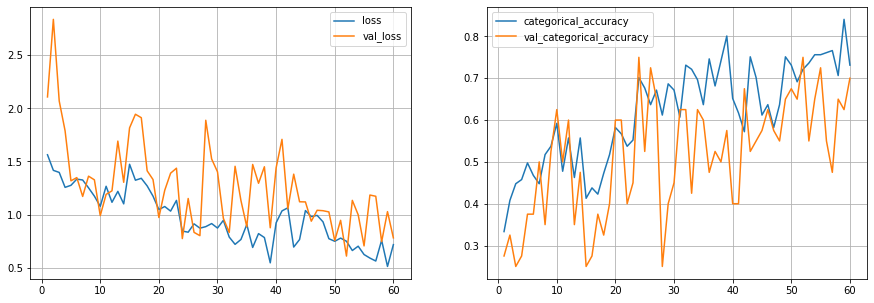

In [60]:
draw_evaluation_metric(file_path)

In [61]:
# Getting the best checpoint and val , categorical accuracy
path,best_epoch,metric_parms = get_best_check_point(file_path)


Best model name : model_init-00024-0.84458-0.70149-0.77403-0.75000.h5
Best Epoch is 24
Best model validation accuracy is : 0.75
Best model train accuracy is : 0.7014925479888916


In [62]:
param_count_model5 = param_count(model5)

name.append('model_5-GRU-less-filters')
total_params.append(param_count_model5[0] )
trainable_params.append(param_count_model5[1] )
non_trainable_params.append(param_count_model5[2] )


categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 3,670,421
Trainable params: 3,669,973
Non-trainable params: 448


# Observations
- This model seems to be better than the last model as we have managed to increase the validation accuracy and training accuracy.
- Let us try using bidirectional GRU to get even better results.

# Model 6 using bidirectional GRU

In [63]:
# Model6 

tf.keras.backend.clear_session()

model6 = Sequential()

#1st Conv2D group
model6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

#2nd Conv2D group
model6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

#3rd Conv2D group
model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu'), input_shape=input_shape))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
model6.add(TimeDistributed(BatchNormalization()))
model6.add(TimeDistributed(MaxPooling2D((2, 2))))

#FC layer group
model6.add(TimeDistributed(Flatten()))
#GRU bidirectional
model6.add(Bidirectional(GRU(128)))
model6.add(Dropout(0.5))
#Softmax Layer
model6.add(Dense(5, activation='softmax'))

In [64]:
optimiser = Adam() #write your optimizer
model6.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
model6.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
time_distributed (TimeDistri (None, 15, 100, 100, 16)  448       
_________________________________________________________________
time_distributed_1 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_2 (TimeDist (None, 15, 100, 100, 16)  2320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 15, 100, 100, 16)  64        
_________________________________________________________________
time_distributed_4 (TimeDist (None, 15, 50, 50, 16)    0         
_________________________________________________________________
time_distributed_5 (TimeDist (None, 15, 50, 50, 32)    4640      
_________________________________________________________________
time_distributed_6 (TimeDist (None, 15, 50, 50, 32)    1

In [65]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model6')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model6


In [66]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : No weight and model is saved yet.
Latest Epoch is None


In [67]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)
    
    model6_fit = tf.keras.models.load_model(latest_weight)

model6_fit = model6.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=num_epochs,
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Epoch 1/60
67/67 [==============================] - 20s 269ms/step - loss: 2.1731 - categorical_accuracy: 0.1841 - val_loss: 2.2635 - val_categorical_accuracy: 0.3000

Epoch 00001: saving model to save_model/conv2d_RNN/model6\model_init-00001-2.17313-0.18408-2.26346-0.30000.h5
Epoch 2/60
67/67 [==============================] - 19s 287ms/step - loss: 1.8660 - categorical_accuracy: 0.2935 - val_loss: 3.8173 - val_categorical_accuracy: 0.1250

Epoch 00002: saving model to save_model/conv2d_RNN/model6\model_init-00002-1.86604-0.29353-3.81734-0.12500.h5
Epoch 3/60
67/67 [==============================] - 21s 314ms/step - loss: 1.8801 - categorical_accuracy: 0.3234 - val_loss: 2.5885 - val_categorical_accuracy: 0.1750

Epoch 00003: saving model to save_model/conv2d_RNN/model6\model_init-00003-1.88006-0.32338-2.58849-0.17500.h5
Epoch 4/60
67/67 [==============================] - 19s 279ms/step - loss: 1.9241 - categorical_accuracy: 0.2488 - val_loss: 1.8003 - val_categorical_accuracy: 0.3500

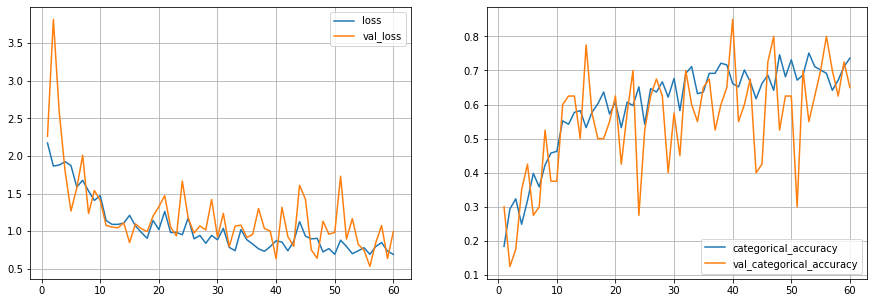

In [68]:
draw_evaluation_metric(file_path)

In [69]:
# Getting the best checpoint and val , categorical accuracy
path,best_epoch,metric_parms = get_best_check_point(file_path)


Best model name : model_init-00040-0.87251-0.66169-0.63309-0.85000.h5
Best Epoch is 40
Best model validation accuracy is : 0.8500000238418579
Best model train accuracy is : 0.6616915464401245


In [70]:
param_count_model6 = param_count(model6)

name.append('model_6-GRU-bidirectional')
total_params.append(param_count_model6[0] )
trainable_params.append(param_count_model6[1] )
non_trainable_params.append(param_count_model6[2] )


categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 7,251,989
Trainable params: 7,251,541
Non-trainable params: 448


# Observations
- This model is having good validation accuracy but low train accuracy.
- We will try to get better model by using transfer learning and using VGG-19 as pre trained model.

# Model 7 Transfer Learning
Setting up base information for model building process.

*IMPORTANT*
We are using VGG19 pre-trained model for CONV2D modelling.

If this code is CONV2D+RNN type modelling, then we will use *base_model* and *preprocess_input_func* variables further in the code.

In [99]:
train_data = train_doc
val_data = val_doc
#transform_size = (100,100)
batch_size = 32
num_epochs = num_epochs
num_train_sequences = len(train_data)
num_val_sequences = len(val_data)
model_name = "model_init"

tf.keras.backend.clear_session()

from tensorflow.keras.applications.vgg19 import VGG19 as base_conv2d_model
from tensorflow.keras.applications.vgg19 import preprocess_input

base_model = base_conv2d_model(weights="imagenet",include_top=False)

os.environ.putenv("HDF5_USE_FILE_LOCKING","FALSE")

#### Building Neural Network Model Architecture ####

In [100]:
input_sample = next(generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              frame_selection = get_frame_selection_list(choice_of_list=0), 
                              process_input_func = preprocess_input,
                              base_model=base_model))
print("Input Sample shape : %s" %(str(input_sample[0].shape)))

model = Sequential()
model.add(SimpleRNN(64,
                    return_sequences = True,
                    input_shape=(input_sample[0].shape[1],input_sample[0].shape[2])))
model.add(SimpleRNN(64))
model.add(Dense(input_sample[1].shape[1], activation='softmax'))

Source path =  C:\Data\Project_data\train ; batch size = 32
Input Sample shape : (32, 30, 4608)


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [101]:
optimiser = SGD(lr=0.01)#write your optimizer
model.compile(optimizer=optimiser, loss='categorical_crossentropy',metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 30, 64)            299072    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 64)                8256      
_________________________________________________________________
dense (Dense)                (None, 5)                 325       
Total params: 307,653
Trainable params: 307,653
Non-trainable params: 0
_________________________________________________________________
None


Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

#### Building up generator objects ####

train_generator for training data

val_generator for validation data

In [102]:
train_generator = generator(train_path,
                              train_data, 
                              batch_size=batch_size,
                              frame_selection = get_frame_selection_list(choice_of_list=0), 
                              process_input_func = preprocess_input,
                              base_model=base_model)
val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          frame_selection = get_frame_selection_list(choice_of_list=0), 
                          process_input_func = preprocess_input,
                          base_model=base_model)

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [103]:
callbacks_list,file_path = get_model_callback_list('conv2d_RNN','model7')
print("Model to be saved in directory : %s" %(os.path.dirname(file_path)))

Model to be saved in directory : save_model/conv2d_RNN/model7


In [104]:
latest_weight,latest_epoch=get_latest_check_point(file_path)

Latest model name : model_init-00003-1.15818-0.56541-1.32920-0.42500.h5
Latest Epoch is 3


Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

# Fitting the Model7 (CONV2D+RNN (transfer learning)) with 30 epochs

In [105]:
if latest_epoch==None:
    last_epoch=0
else:
    last_epoch=latest_epoch  #Start training where we left using initial_epoch
    print("Starting the training from epoch: ",last_epoch+1)
    print("Loading latest model and weight from file:",latest_weight)

    model=tf.keras.models.load_model(latest_weight)

conv2d_simple_rnn_model = model.fit(x=train_generator,
                                    steps_per_epoch=steps_per_epoch,
                                    initial_epoch=last_epoch,
                                    epochs=30,#num_epochs,Not running it for 60 epoch considering time issue and results above. 
                                    verbose=1, 
                                    callbacks=callbacks_list,
                                    validation_data=val_generator,
                                    validation_steps=validation_steps,
                                    workers=1)

Starting the training from epoch:  4
Loading latest model and weight from file: save_model/conv2d_RNN/model7\model_init-00003-1.15818-0.56541-1.32920-0.42500.h5
Source path =  C:\Data\Project_data\train ; batch size = 32
Epoch 4/30
67/67 [==============================] - 444s 7s/step - loss: 1.0283 - categorical_accuracy: 0.6064 - val_loss: 0.9050 - val_categorical_accuracy: 0.7016

Epoch 00004: saving model to save_model/conv2d_RNN/model7\model_init-00004-1.02829-0.60643-0.90500-0.70161.h5
Epoch 5/30
67/67 [==============================] - 299s 5s/step - loss: 1.0024 - categorical_accuracy: 0.6113 - val_loss: 0.9848 - val_categorical_accuracy: 0.5250

Epoch 00005: saving model to save_model/conv2d_RNN/model7\model_init-00005-1.00235-0.61125-0.98482-0.52500.h5
Epoch 6/30
67/67 [==============================] - 293s 4s/step - loss: 0.8434 - categorical_accuracy: 0.7041 - val_loss: 1.0332 - val_categorical_accuracy: 0.5500

Epoch 00006: saving model to save_model/conv2d_RNN/model7\mod

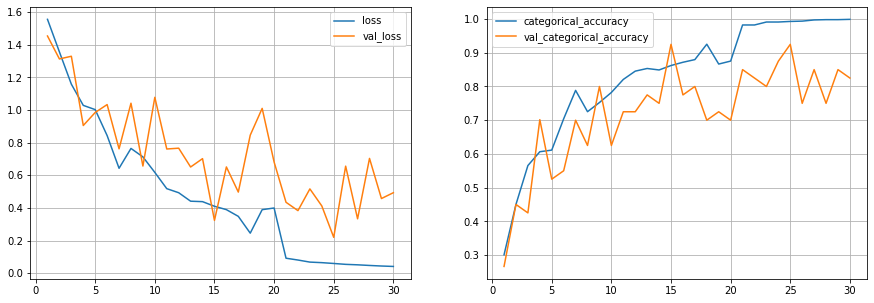

In [106]:
draw_evaluation_metric(file_path)

In [107]:
path,best_epoch,metric_parms = get_best_check_point(file_path)#get_best_check_point('save_model/conv2d_RNN/model1')

Best model name : model_init-00015-0.41033-0.86216-0.32377-0.92500.h5
Best Epoch is 15
Best model validation accuracy is : 0.925000011920929
Best model train accuracy is : 0.862159788608551


In [108]:
param_count_tr_lear_model = param_count(model)

name.append('Model7-transfer_learning')
total_params.append(param_count_tr_lear_model[0] )
trainable_params.append(param_count_tr_lear_model[1] )
non_trainable_params.append(param_count_tr_lear_model[2] )

categorical_accuracy.append(metric_parms[0])
val_categorical_accuracy.append(metric_parms[1])
paths.append(path)

Total params: 307,653.0
Trainable params: 307,653
Non-trainable params: 0.0


# Observations
- This model build on a transfer learning approach seems to give good validation nad training accuracy.
- It has better accuracy than SimpleRNN, LSTM , GRU or bidirectional GRU models.

# Analysis of all the models created above

In [109]:
# Creating all the model metrics in a dataframe, printing and plotting it.
data2 = {'name': name,
        'total_params': total_params,
        'trainable_params': trainable_params,
        'non_trainable_params': non_trainable_params,
        'categorical_accuracy':categorical_accuracy,
        'val_categorical_accuracy': val_categorical_accuracy,
        'paths':paths}

model_params2 = pd.DataFrame(data2)

In [110]:
model_params2

,name,total_params,trainable_params,non_trainable_params,categorical_accuracy,val_categorical_accuracy,paths
0,model1-SimpleRNN,2673189.0,2672293,896.0,0.502488,0.625,save_model/conv2d_RNN/model1\model_init-00022-...
1,model2-LSTM,9800613.0,9799717,896.0,0.577114,0.700,save_model/conv2d_RNN/model2\model_init-00031-...
2,model_3-LSTM-less-filters,4866197.0,4865749,448.0,0.601990,0.725,save_model/conv2d_RNN/model3\model_init-00029-...
3,model_4-GRU,7425189.0,7424293,896.0,0.646766,0.750,save_model/conv2d_RNN/model4\model_init-00044-...
4,model_5-GRU-less-filters,3670421.0,3669973,448.0,0.701493,0.750,save_model/conv2d_RNN/model5\model_init-00024-...
5,model_6-GRU-bidirectional,7251989.0,7251541,448.0,0.661692,0.850,save_model/conv2d_RNN/model6\model_init-00040-...
6,Model7-transfer_learning,307653.0,307653,0.0,0.862160,0.925,save_model/conv2d_RNN/model7\model_init-00015-...


### Plotting the trainable params for models.

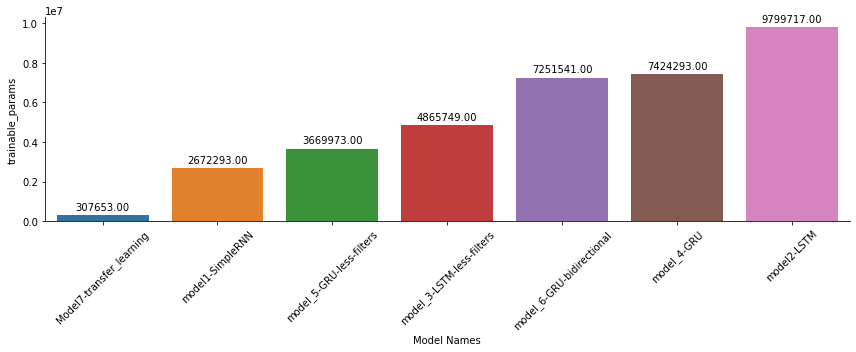

In [111]:
import seaborn as sns
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="name", y="trainable_params", data=model_params2, order=model_params2.sort_values('trainable_params').name)
ax = annotate_graph(ax)
sns.despine()
plt.xticks(rotation = 45)
plt.xlabel('Model Names')
plt.tight_layout()

### Plotting the training accuracy for models.

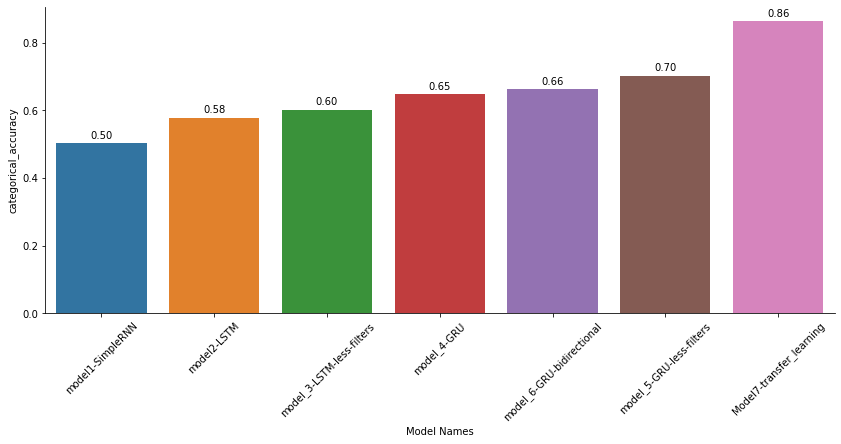

In [112]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="name", y="categorical_accuracy", data=model_params2, order=model_params2.sort_values('categorical_accuracy').name)
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()
plt.xticks(rotation = 45)
plt.xlabel('Model Names')
plt.show()

### Plotting the validation accuracy for models.

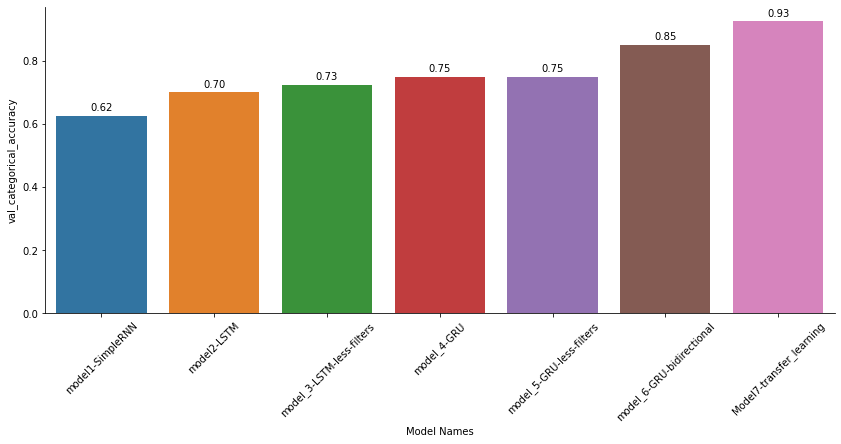

In [113]:
fig = plt.figure(figsize=(12,5))
ax = sns.barplot(x="name", y="val_categorical_accuracy", data=model_params2, order=model_params2.sort_values('val_categorical_accuracy').name)
ax = annotate_graph(ax)
sns.despine()
plt.tight_layout()
plt.xticks(rotation = 45)
plt.xlabel('Model Names')
plt.show()

# Observations
 - As seen in the above plots the model using transfer learning is performing the best.
 - The training and validation accuracy for this model7 is reasonably good.
 - The number of trainable parameters for model7 using transfer learning is also comparatively less.
 - So, we can consider this model as best among others.
 - Other models using LSTM,GRU,Bidirectional-GRU is not not as good as Model7-transfer-learning.

# Loading the best model

### Selecting h5 file for loading model

In [114]:
# Finding the index of the best model
idx_model = np.argmax(model_params2.val_categorical_accuracy)
print('Best model is ',model_params2['name'][idx_model])

Best model is  Model7-transfer_learning


In [115]:
path = model_params2['paths'][idx_model]
print('Path to the best weight is :: ',path)
selected_model = tf.keras.models.load_model(path)

Path to the best weight is ::  save_model/conv2d_RNN/model7\model_init-00015-0.41033-0.86216-0.32377-0.92500.h5


#### Performing prediction on validation data ####

In [116]:
if model_params2['name'][idx_model] == 'Model7-transfer_learning':
    testing_val_generator = generator(val_path,
                          val_data, 
                          batch_size=batch_size,
                          frame_selection = get_frame_selection_list(choice_of_list=0), 
                          process_input_func = preprocess_input,
                          base_model=base_model)
else:
    testing_val_generator = generator(val_path, val_doc, batch_size,
                                      frame_selection = get_frame_selection_list(choice_of_list=1))
result = None
for x in range(validation_steps):
    x_val,y_val = next(testing_val_generator)
    p_val = selected_model.predict(x_val,batch_size=batch_size,verbose=1)
    if x == 0:
        result = np.vstack((y_val.argmax(axis=1),p_val.argmax(axis=1)))
    else:
        result = np.hstack((result,np.vstack((y_val.argmax(axis=1),p_val.argmax(axis=1)))))

Source path =  C:\Data\Project_data\val ; batch size = 32
1/1 [==============================] - 0s 16ms/step


#### Consolidating Results ####

In [117]:
result = pd.DataFrame(np.transpose(result),columns=["Actual","Predicted"])

In [118]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [119]:
cf_np = confusion_matrix(result.Actual,result.Predicted,labels=range(0,5))
cf_df = pd.DataFrame(cf_np,columns=["Predicted_" + str(x) for x in ["Left","Right","Stop","Down","Up"]],
                     index=["Actual_" + str(x) for x in ["Left","Right","Stop","Down","Up"]])
cf_df

,Predicted_Left,Predicted_Right,Predicted_Stop,Predicted_Down,Predicted_Up
Actual_Left,11,6,1,4,0
Actual_Right,0,27,0,0,0
Actual_Stop,1,1,25,0,0
Actual_Down,0,2,0,27,0
Actual_Up,0,2,0,3,14


In [120]:
print("Cumulative General Accuracy Score : %f" %(accuracy_score(result.Actual,result.Predicted)))

Cumulative General Accuracy Score : 0.838710
